# 実習7-3
#### RNNを用いて文章の感情分析をします。

この実習では以下の書籍の3章と6章を参考にしています。

PythonとKerasによるディープラーニング
(https://www.amazon.co.jp/PythonとKerasによるディープラーニング-Francois-Chollet/dp/4839964262)

IMDbデータセットを使用します。これはIMDb(Internet Movie Database)から収集された「肯定的」25000件と「否定的」25000件のレビューで構成されている。

### データの前処理

In [1]:
# まずはIMDbデータセットをダウンロードする

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 #訓練データにおいて出現頻度が最も高い10000個の単語だけを残し、出現頻度が低い単語は捨てます。
maxlen = 500 #一つの文章につき最大500単語まで取り出す
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequences
25000 test sequences


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
# x_trainには単語IDが順番に入っています。y_trainにはレビューが肯定的か否定的かを表す0と1が入っています。
print(x_train[0])
print(y_train[0:10])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1 0 0 1 0 0 1 0 1 0]


In [3]:
# 1文目のデータ(x_train[0])を文章に戻してみる。

# word_indexは単語を整数のインデックス(単語ID)にマッピングする辞書(jsonファイル)、これをダウンロードする
word_index = imdb.get_word_index()

# 整数のインデックスを単語にマッピング　(単語と単語IDを入れ替える)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# レビューをデコード：インデックスのオフセットとして3が指定されているのは、0, 1, 2はそれぞれ「パディング」「シーケンスの開始」
# 「不明」のインデックスとして予約されているためである。登録されていないキーに対しては?を返す。
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in x_train[0]])

print (decoded_review)

1646592/1641221 [==============================] - 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

In [4]:
#word_indexとreverse_word_indexの中を見てみる
a = [(x,y) for (i, (x, y)) in enumerate(word_index.items()) if i<5]
b = [(x,y) for (i, (x, y)) in enumerate(reverse_word_index.items()) if i<5]
print(a)
print(b)

[('fawn', 34701), ('tsukino', 52006), ('nunnery', 52007), ('sonja', 16816), ('vani', 63951)]
[(34701, 'fawn'), (52006, 'tsukino'), (52007, 'nunnery'), (16816, 'sonja'), (63951, 'vani')]


In [5]:
# 単語ID1から20の英単語を表示
tango = []
for i in range (1, 21):
    tango.append(reverse_word_index[i])
print(tango)

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on']


In [6]:
# 1つのデータ(文章)を500次元のベクトルに変換する。単語数が足りない文章は0で埋める。
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [7]:
# validation dataの準備
x_val = x_train[:5000]
partial_x_train = x_train[5000:]

y_val = y_train[:5000]
partial_y_train = y_train[5000:]

#### まずはEmbeddingとDense層のみで分類してみる

In [8]:
epochs = 20
batch_size = 128

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する、単語数(t)は500。

# 3次元テンソルを形状が(samples, max_len*32)の2階のテンソルに変換
model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16001     
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


kerasのEmbeddingは正の整数（インデックス）を固定次元の密ベクトル(対応する単語ベクトル)に変換します。埋め込み空間を誤差逆伝播により学習することができます。

model.add(Embedding(10000, 32, input_length=500))において、

input_dim: 正の整数．語彙数．

output_dim: 0以上の整数．密なembeddingsの次元数．

input_length: 入力の系列長（定数）．

自然言語処理での使い方としては、Embedding(語彙数, 分散ベクトルの次元数, 1文章の次元数))となります。


In [10]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (x_val, y_val))

Epoch 1/20
157/157 [==============================] - 4s 12ms/step - loss: 0.6633 - accuracy: 0.5932 - val_loss: 0.4178 - val_accuracy: 0.8402
Epoch 2/20
157/157 [==============================] - 1s 9ms/step - loss: 0.3362 - accuracy: 0.8819 - val_loss: 0.3231 - val_accuracy: 0.8592
Epoch 3/20
157/157 [==============================] - 1s 9ms/step - loss: 0.2186 - accuracy: 0.9203 - val_loss: 0.2647 - val_accuracy: 0.8932
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 0.1698 - accuracy: 0.9420 - val_loss: 0.2604 - val_accuracy: 0.8956
Epoch 5/20
157/157 [==============================] - 1s 9ms/step - loss: 0.1307 - accuracy: 0.9595 - val_loss: 0.2741 - val_accuracy: 0.8910
Epoch 6/20
157/157 [==============================] - 1s 9ms/step - loss: 0.1041 - accuracy: 0.9684 - val_loss: 0.2807 - val_accuracy: 0.8866
Epoch 7/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0790 - accuracy: 0.9796 - val_loss: 0.2809 - val_accuracy: 0.8940
Epo

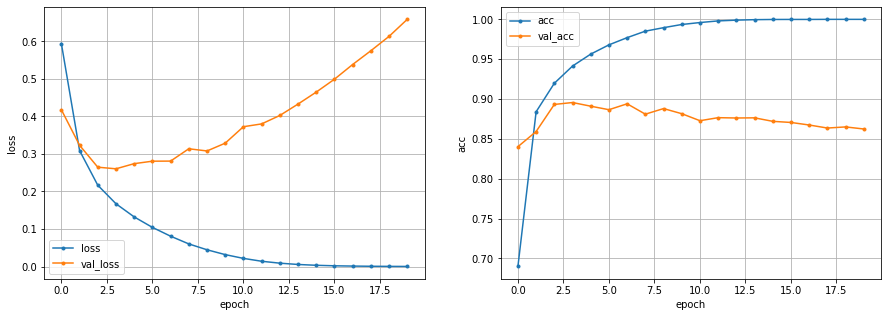

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

#### RNNを使ってみる

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する、単語数(t)は500。
model.add(SimpleRNN(32)) #SimpleRNNの入力次元は3次元で(batchsize, timesteps(ここでは単語ベクトルの数), 単語ベクトルの次元数)となる
model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

# simpleRNNのparameter数2080はhw+xw+bを考えると、32^2+32^2+32で求まる。

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = 10,
                 batch_size = 128,
                 validation_data = (x_val, y_val))

Epoch 1/10
157/157 [==============================] - 52s 329ms/step - loss: 0.6257 - accuracy: 0.6393 - val_loss: 0.4622 - val_accuracy: 0.7812
Epoch 2/10
157/157 [==============================] - 51s 328ms/step - loss: 0.3681 - accuracy: 0.8495 - val_loss: 0.3335 - val_accuracy: 0.8622
Epoch 3/10
157/157 [==============================] - 53s 337ms/step - loss: 0.2954 - accuracy: 0.8796 - val_loss: 0.3427 - val_accuracy: 0.8554
Epoch 4/10
157/157 [==============================] - 52s 330ms/step - loss: 0.2208 - accuracy: 0.9154 - val_loss: 0.4533 - val_accuracy: 0.8040
Epoch 5/10
157/157 [==============================] - 51s 325ms/step - loss: 0.1716 - accuracy: 0.9393 - val_loss: 0.3696 - val_accuracy: 0.8592
Epoch 6/10
157/157 [==============================] - 52s 331ms/step - loss: 0.1225 - accuracy: 0.9586 - val_loss: 0.5024 - val_accuracy: 0.7778
Epoch 7/10
157/157 [==============================] - 52s 330ms/step - loss: 0.0920 - accuracy: 0.9707 - val_loss: 0.4728 - val_ac

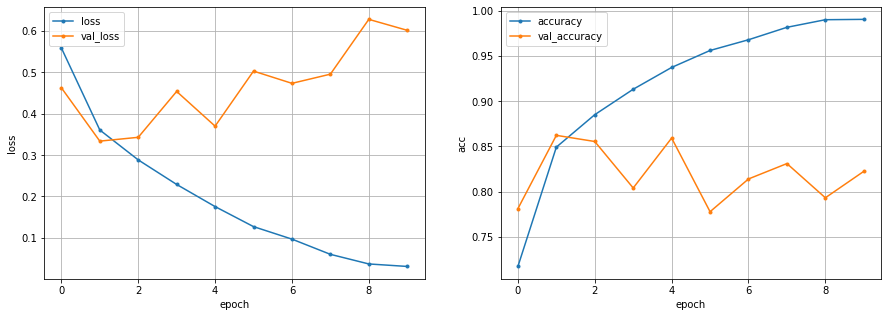

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = 10

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='accuracy')
plt.plot(range(epochs), val_acc, marker='.', label='val_accuracy')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

### LSTMを使ってみる

In [15]:
# SimpleRNNをLSTMに変更するだけ
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) 
model.add(LSTM(32)) 
model.add(Dense(1, activation = 'sigmoid')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = 10,
                 batch_size = 512,
                 validation_data = (x_val, y_val))

Epoch 1/10
40/40 [==============================] - 9s 62ms/step - loss: 0.6694 - accuracy: 0.6135 - val_loss: 0.6020 - val_accuracy: 0.6310
Epoch 2/10
40/40 [==============================] - 2s 52ms/step - loss: 0.4787 - accuracy: 0.7969 - val_loss: 0.4784 - val_accuracy: 0.7864
Epoch 3/10
40/40 [==============================] - 2s 52ms/step - loss: 0.3618 - accuracy: 0.8655 - val_loss: 0.3897 - val_accuracy: 0.8226
Epoch 4/10
40/40 [==============================] - 2s 52ms/step - loss: 0.2977 - accuracy: 0.8868 - val_loss: 0.2891 - val_accuracy: 0.8866
Epoch 5/10
40/40 [==============================] - 2s 52ms/step - loss: 0.2493 - accuracy: 0.9074 - val_loss: 0.6491 - val_accuracy: 0.8156
Epoch 6/10
40/40 [==============================] - 2s 52ms/step - loss: 0.3054 - accuracy: 0.8976 - val_loss: 0.4356 - val_accuracy: 0.8370
Epoch 7/10
40/40 [==============================] - 2s 52ms/step - loss: 0.2111 - accuracy: 0.9224 - val_loss: 0.2842 - val_accuracy: 0.8830
Epoch 8/10
40

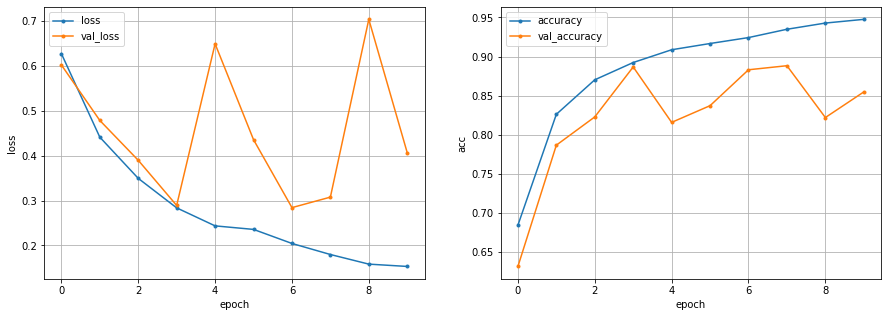

In [17]:
import matplotlib.pyplot as plt
loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='accuracy')
plt.plot(range(epochs), val_acc, marker='.', label='val_accuracy')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

### 課題7-3-1
#### SimpleRNN層を連続で二層繋いでより表現力の高いモデルを構築してみましょう
SimpleRNN(32, return_sequences = True)とすることで出力が3階のテンソル(batchsize, timesteps, output_features)になります。次の層のSimepleRNNが情報を受け取ることができるようになります。return_sequencesの引数を指定しない場合、SimpleRNNの出力は2次元のテンソル(batchsize, output_features)となりの、これは一番最後のRNNの出力です。

### 課題7-3-2
#### GloVeの埋め込み行列を使って学習を行ってみてください。

単語の埋め込みについて、データベースが色々提供されています。それらをダウンロードすればkerasのEmbedding層で利用できます。Word2vecはそのうちの1つです。また、2014年にスタンフォード大学の研究者によって開発されたGlobal Vectors for Word Representation(GloVe)というアルゴリズムがよく知られています。この埋め込みアルゴリズムは、単語の共起関係からなる行列の因数分解に基づいています。GloVeの開発者はWikipediaやCommmon Crawlのデータから取得した数百万規模の英語のトークンをもとに学習済みの埋め込みを提供しています。
GloVe単語埋め込みファイル(glove.6B.zip)は以下のURLよりダウンロードして解凍してください。このファイルには40万個の単語を対象とした100次元の埋め込みベクトルが含まれています。

https://nlp.stanford.edu/projects/glove

In [18]:
# 課題7-3-1
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する
model.add(SimpleRNN(32, return_sequences = True)) #このSimpleRNNの出力次元は3次元となる
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 500, 32)           2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 324,193
Trainable params: 324,193
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = 10,
                 batch_size = 512,
                 validation_data = (x_val, y_val))

Epoch 1/10
40/40 [==============================] - 27s 649ms/step - loss: 0.6850 - accuracy: 0.5550 - val_loss: 0.4790 - val_accuracy: 0.7708
Epoch 2/10
40/40 [==============================] - 25s 638ms/step - loss: 0.4492 - accuracy: 0.7958 - val_loss: 0.5432 - val_accuracy: 0.7170
Epoch 3/10
40/40 [==============================] - 26s 639ms/step - loss: 0.3413 - accuracy: 0.8603 - val_loss: 0.4077 - val_accuracy: 0.8344
Epoch 4/10
40/40 [==============================] - 26s 649ms/step - loss: 0.2612 - accuracy: 0.8956 - val_loss: 0.4225 - val_accuracy: 0.8118
Epoch 5/10
40/40 [==============================] - 26s 639ms/step - loss: 0.1848 - accuracy: 0.9313 - val_loss: 0.3730 - val_accuracy: 0.8566
Epoch 6/10
40/40 [==============================] - 26s 640ms/step - loss: 0.1319 - accuracy: 0.9521 - val_loss: 0.5518 - val_accuracy: 0.7664
Epoch 7/10
40/40 [==============================] - 26s 646ms/step - loss: 0.0779 - accuracy: 0.9759 - val_loss: 0.6323 - val_accuracy: 0.7750

In [20]:
# 課題7-3-2
#演習の授業用にdropboxにアップロードしておきましたので、そこからデータセットをダウンロードします
import urllib.request 

url = "https://www.dropbox.com/s/30vbeo4v8w5wml4/glove.zip?dl=1" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "glove.zip" # recordings.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

('glove.zip', <http.client.HTTPMessage at 0x7fa31ebfa438>)

In [21]:
#uploadしたzipファイルを解凍する
import zipfile
with zipfile.ZipFile("glove.zip","r") as zip_ref:
    zip_ref.extractall("") #""の中にはディレクトリのpathが入る

In [22]:
import os
import numpy as np

#  Gloveの埋め込みファイルが置かれているディレクトリを指定
glove_dir = 'glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('Found %ds word vectors.' % len(embeddings_index))

Found 400000s word vectors.


In [23]:
#GloVeの単語埋め込み行列の準備
max_features = 10000
embedding_dim = 100
max_words = 40000

embedding_matrix = np.zeros((max_features, embedding_dim))
for word in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            #埋め込みインデックスで見つからない単語は0で埋める
            embedding_matrix[i] = embedding_vector

In [24]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 100, input_length = 500)) #10000種類の単語に対して100次元の埋め込みを学習する
model.add(SimpleRNN(32, return_sequences = True)) #このSimpleRNNの出力次元は3次元となる
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 500, 32)           4256      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,006,369
Trainable params: 1,006,369
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
# VGG16の時と同様で、後ろの層が初期化された状態でEmbedding層の重みを学習可能にしてしまうと折角の表現が壊れてしまいます。
# そのため、trainable属性をFalseにします。

In [26]:
epochs = 10
batch_size = 128

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
hist = model.fit(x_train, y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (x_val, y_val))

Epoch 1/10
196/196 [==============================] - 112s 566ms/step - loss: 0.6974 - acc: 0.5000 - val_loss: 0.6991 - val_acc: 0.4908
Epoch 2/10
196/196 [==============================] - 111s 566ms/step - loss: 0.6955 - acc: 0.4977 - val_loss: 0.6977 - val_acc: 0.5092
Epoch 3/10
196/196 [==============================] - 112s 571ms/step - loss: 0.6954 - acc: 0.5053 - val_loss: 0.6997 - val_acc: 0.5092
Epoch 4/10
196/196 [==============================] - 111s 567ms/step - loss: 0.6967 - acc: 0.5015 - val_loss: 0.6950 - val_acc: 0.5092
Epoch 5/10
196/196 [==============================] - 114s 582ms/step - loss: 0.6948 - acc: 0.4965 - val_loss: 0.6934 - val_acc: 0.4908
Epoch 6/10
196/196 [==============================] - 113s 577ms/step - loss: 0.6951 - acc: 0.5081 - val_loss: 0.6930 - val_acc: 0.5092
Epoch 7/10
196/196 [==============================] - 112s 571ms/step - loss: 0.6951 - acc: 0.4973 - val_loss: 0.6939 - val_acc: 0.4908
Epoch 8/10
196/196 [============================

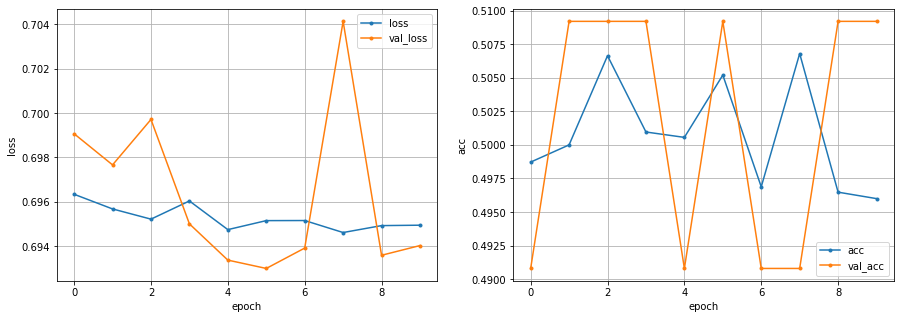

In [27]:
import matplotlib.pyplot as plt
loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

あまり正答率が良くならないですね。
Gloveが獲得した表現はIMDbのレビューとは相性が悪いのかもしれませんが。。。

#### (おまけ)　Embeddingを使わずDenseのみで分類してみる

In [28]:
# kerasで用意されているIMDbデータセットの読み込み
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

#引数num_words=10000は、訓練データにおいて出現頻度が最も高い10000個の単語だけを残し、出現頻度が低い単語は捨てることを意味します。

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [29]:
#データの中身を見てみる。
print('traindata[0]:',train_data[0]) # 単語IDが並ぶ
print('train_labels[0]:',train_labels[0]) # 0は否定的、1は肯定的を表す

traindata[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
train_labels[0]: 1


In [30]:
# 語彙数 (単語数を10000に設定しているため、10000を超えることはない(9999))
max([max(sequence) for sequence in train_data])

9999

In [31]:
# 1文目のデータ(x_train[0])を文章に戻す。

# word_indexは単語を整数のインデックスにマッピングする辞書
word_index = imdb.get_word_index()

# 整数のインデックスを単語にマッピング
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# レビューをデコード：院でクスのオフセットとして3が指定されているのは、0, 1, 2はそれぞれ「パディング」「シーケンスの開始」
# 「不明」のインデックスとして予約されているためである。登録されていないキーに対しては?を返す。
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

print (decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [32]:
# 単語IDのシーケンスをone-hotベクトルに変換
import numpy as np
def vectorize_sequences(sequences, dimension =10000):
    
    #形状が(len(sequences), dimension)の行列を作成し、0で埋める
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # results[i]のインデックスを1に設定
    return results

# 訓練データのベクトル化
x_train = vectorize_sequences(train_data)

# テストデータのベクトル化
x_test = vectorize_sequences(test_data)

In [33]:
# x_trainの中身を見てみる。25000個の訓練データ、1つの訓練データ(1つの文章)が1万次元の要素を持つ。
# 肯定的な単語や否定的な単語が何番目の次元か推定できれば、その文章が肯定的か否定的か判別がつきそうですね。
print(x_train, x_train.shape)
print(x_train[0][0:20])

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]] (25000, 10000)
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [34]:
# ラベルのベクトル化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print(y_train, y_train.shape)

[1. 0. 0. ... 0. 1. 0.] (25000,)


In [35]:
# validation dataの準備
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [36]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = (10000,)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,282,209
Trainable params: 1,282,209
Non-trainable params: 0
_________________________________________________________________


In [37]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [38]:
# 学習
epochs = 20
batch_size = 512

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 40ms/step - loss: 0.5652 - accuracy: 0.6810 - val_loss: 0.3282 - val_accuracy: 0.8700
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2632 - accuracy: 0.9004 - val_loss: 0.2753 - val_accuracy: 0.8898
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1806 - accuracy: 0.9367 - val_loss: 0.2769 - val_accuracy: 0.8894
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1233 - accuracy: 0.9593 - val_loss: 0.2867 - val_accuracy: 0.8869
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0843 - accuracy: 0.9758 - val_loss: 0.3210 - val_accuracy: 0.8816
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0666 - accuracy: 0.9815 - val_loss: 0.3525 - val_accuracy: 0.8764
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0419 - accuracy: 0.9899 - val_loss: 0.3674 - val_accuracy: 0.8808
Epoch 8/20
30

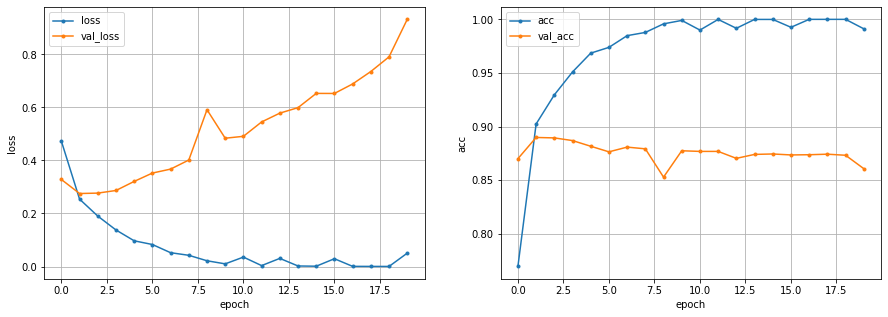

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()